# Probability distributions in bayesian modelling
> Understanding how probability distributions are used in bayesian modelling using an example

- sticky_rank: 1
- toc: true 
- badges: true
- comments: true
- hide: false
- categories: [beta distribution, binomial distribution, pymc3, random-walk-metropolis, conjucate-prior, bayesian modelling]
- image: images/bayesian_beta_binom.png

## Introduction
Probability distributions are one of the core concepts of bayesian modelling. Any problem begins with thinking about these distribution. Prior, likelikhood, posterior in bayesian modelling are defined as probability distributions. This blog post is not about listing down all the probability distributions instead it aims is to make the reader understand about a probability distribution and how/why/when it is used in bayesian modelling. The blogpost divided into the following sections 

In [2]:
import matplotlib.pyplot as plt
plt.style.use("bmh") ## use bayesian modeling pymc3 book style
import matplotlib
import numpy as np 
import scipy.stats as sps
import arviz as az

## Simple Problem
Suppose you and your friends are playing coin toss game, for every head, you will get \\$1 and for every tail you will lose \\$1. Suppose this is a fair coin and you play enough times, you are sure of not loosing or gaining any money as the probability of heads or tails is 1/2. But, after playing a few games you observed that you are loosing money and now you feel that the coin is baised. You want to now calcuate P(coin baised or not/given data). we will assume $\theta$ to be whether the coin baised or not and y to be the given data. so we want to calculate $P(\theta/y)$.

so using bayes theorm, 
$$
P(\theta/y) = (p(\theta) * p(y/\theta) ) / p(y)
$$

where 
> $P(\theta)$ - prior  
> $P(y/\theta)$ - likelihood  
> $P(y)$ - normalizing constant  
> $P(\theta/y)$ - posterior  
> $P(\theta, y)$ = likelihood * prior = joint distribution

## Understanding likelihood - binomial distribution
- For probability of success in N trails we generally use [binomial distribution](https://en.wikipedia.org/wiki/Binomial_distribution).
$$
P(y/\theta, N) =\binom{n}{y} * (\theta)^{y} * (\theta)^{N-y}
$$

Now suppose we have intialized an experiment and observed various values of success. Let that be 
> y = [10, 20, 50, 100, 500]  
> N = [50, 100, 200, 300, 1000]  

since binomial distribution is a discrete probability distribution, we calculate the likelihood by discretising the probability distribution

In [2]:
y = [10, 20, 50, 100, 500]
N = [50, 100, 200, 300, 1000]
theta = np.linspace(0, 1, 100)[:, None]
pmf = sps.binom.pmf(y, N, theta)

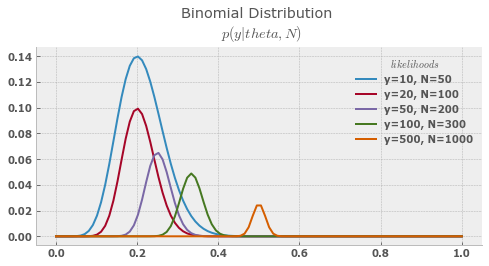

In [3]:
fig, ax = plt.subplots(figsize=(8,3.5))

ax.set(title='Binomial Distribution \n $p(y|theta, N)$')

ax.plot(theta, pmf)
labels = [f"y={i}, N={j}" for i, j in zip(y, N)]
plt.legend(title="$likelihoods$", labels=labels);
plt.show()

The above figure is the likelihood function for various experiments we have done. The concept of MLE (maximum likelihood estimation) came from here and is quite popular in frequentist approach. This is simply calculated as the  x value at which maximum y (likelihood) value is obtained.

Note that likelihood is not a valid probability distribution, the area under the curve is not equal to 1.

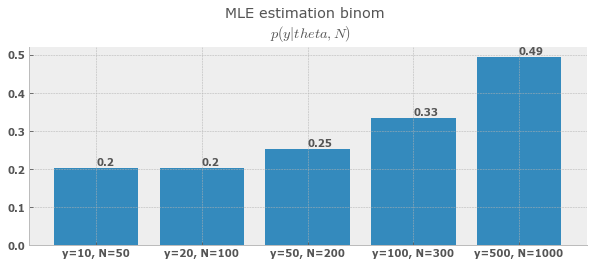

In [4]:
mle = theta[pmf.argmax(0)].reshape(-1)

fig, ax = plt.subplots(figsize=(10,3.5))

ax.set(title='MLE estimation binom \n $p(y|theta, N)$')

ax.bar(labels, mle)
for group in range(len(mle)):
    ax.text(labels[group], mle[group]+0.015, np.round(mle[group], 2), fontsize=10,
                verticalalignment="center")
plt.show()

We can use the maximum likelihood estimate to get the point estimates of the $\theta$, but we donot get the credible intervals for our estimate. one way in which frequentists approach this problem is by randomly repeating the same experiment several times and noting down $\theta$ value each time, these are called confidence intervals. Here we will approach this problem using bayesian approach

## Understanding prior - Beta distribution
priors are beliefs on our parameter before looking at the data. Given enough data, the posterior tends to be the same irrespective of the prior we choose. some people prefer flat priors (uniform distribution) so that we are not baised. Some people choose priors based on their experience. Some use posterior of one problem as prior to another problem statement. Here in this case we will use beta distribution 
- It is a conjucate prior to binomial distribution (we will understand this below)
- Beta distribution adopts several shapes like uniform distribution, gaussian distribution and U-like distribution.
- It is always between [0, 1].  

$$
P(\theta)= 1/B(a, b) *  x^{a-1} *  (1-x)^{b-1}
$$
where 
$$
B(a, b) = \Gamma{(a)} \Gamma{(b)} / \Gamma{a+b}
$$
is a normalizing constant

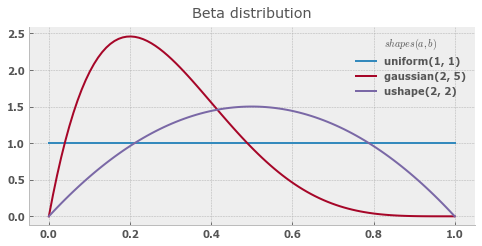

In [5]:
theta = np.linspace(0, 1, 100)[:, None]
uniform_beta = sps.beta.pdf(theta, a=1, b=1)
gaussian_beta = sps.beta.pdf(theta, a=2, b=5)
ushape_beta = sps.beta.pdf(theta, a=2, b=2)
fig, ax = plt.subplots(figsize=(8,3.5))

ax.set(title='Beta distribution')
ax.plot(theta, uniform_beta)
ax.plot(theta, gaussian_beta)
ax.plot(theta, ushape_beta)
labels = ["uniform(1, 1)", "gaussian(2, 5)", "ushape(2, 2)"]
ax.legend(title="$shapes(a, b)$", labels=labels);
plt.show()
plt.show()

## Understanding conjucate priors.
The posterior distribution of $\theta$ is product of prior and likelihood divided by the normalizing constant. we can write that as 
$$
P(\theta/y) = P(\theta,y) / P(y) 
$$
where, 
$$
P(\theta, y) = P(\theta) * P(y/\theta)
$$

If we assume P($\theta$) to be a continous probability distribution, the normalizing constant is equal to 
$$
P(y) = \int_0^1 P(\theta) * P(y/\theta) d\theta
$$

sometimes calculating this integral is difficult as it involves some complex understanding of calculus. some integrals are almost difficult to solve as it involves heirarical distributions, but what if we choose a prior when multiplied by likelihood, falls under the same probability distribution as prior. We will calculate the integral part below analytically below. In our example, we have choosen prior to be beta distribution and likelihood to be binomail distribution


$$ 
P(\theta) * P(y/\theta) = (1/B(a, b) *  \theta^{a-1} *  (1-\theta)^{b-1} ) * \binom{n}{y} * (\theta)^{y} * (\theta)^{N-y}
$$

re-ordering we get

$$
= (1/B(a, b)) * \binom{n}{y} * \theta^{a+y-1} * \theta^{b+N-y-1}
$$

We will consider $\gamma$ to be the constant, so

$$
(1/B(a, b)) * \binom{n}{y} = \gamma
$$

operating on constants we get 
$$
= \gamma * \theta^{a+y-1} * \theta^{b+N-y-1}
$$

Lets call this **equation (1)**
$$
P(\theta) * P(y/\theta) = \gamma * \theta^{a+y-1} * \theta^{b+N-y-1}
$$

To covert this into a valid probability distribution (beta), we need to multiply and divide by B(a+y, b+N-y)

$$
= [\gamma * B(a+y, b+N-y)] * [1/B(a+y, b+N-y) * \theta^{a+y-1} * \theta^{b+N-y-1}]
$$

Now, if we integrate this equation, we get 
$$
P(y) = \int_0^1 P(\theta) * P(y/\theta) d\theta = \gamma * B(a+y, b+N-y) * \int_0^1 1/B(a+y, b+N-y) * \theta^{a+y-1} * \theta^{b+N-y-1} d\theta
$$

The integral part is beta distribution and the area under the curve for beta distribution is 1, so we can rewrite the equation as 

So **equation 2**
$$
P(y) = \gamma * B(a+y, b+N-y) * 1 
$$

Now according to baye's theorm 

$$
P(\theta/y) = P(\theta,y) / P(y) 
$$

From **equation 1 and 2**, we get 

$$
P(\theta/y) = \gamma * \theta^{a+y-1} * \theta^{b+N-y-1} / \gamma * B(a+y, b+N-y)
$$

The $\gamma$ cancels out and we get, 
$$
P(\theta/y) = \theta^{a+y-1} * \theta^{b+N-y-1} /  B(a+y, b+N-y)
$$

The above equation is nothing but a beta distribution with change in shape parameters from a to a+y and b to b+N-y. 

$$
= P(a+y, b+N-y)
$$
where a and b are shapes of our prior beta distribution. 

so, prior beta distribution with shape parameters a and b when multiplied by posterior binomial distribution of y success in N trails is equal to posterior beta distribution with shape parameters a+y and b+N-y. 

So inorder to make our calculations, we can choose prior probabilities which have these nice properties with different likelihood. 


Lets take an example to solve this, We will take random shape parameters of a=2 and b=2. We will assume 3(y) successes in 10 (N)-trails. The posterior distribution can be calculated as follows

In [6]:
x = np.linspace(0, 1, 200)

# priors
prior_a = 2 
prior_b = 2
prior = sps.beta.pdf(x, a=prior_a, b=prior_b)

# likelihood
N = 10
y=3
likelihood = sps.binom.pmf(y, N, x)

# posterior
posterior_a = prior_a+y
posterior_b = prior_b + N - y
posterior = sps.beta.pdf(x, a=posterior_a, b=posterior_b)

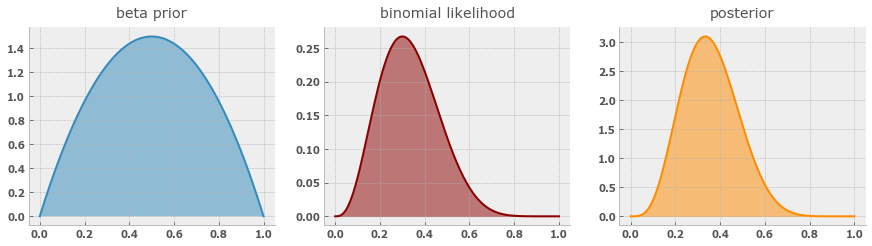

In [7]:
fig, ax = plt.subplots(figsize=(15,3.5), ncols=3, nrows=1)

ax.flat[0].set(title='beta prior')
ax.flat[0].plot(x, prior)
ax.flat[0].fill_between(x, 0, prior, alpha=0.5)
ax.flat[1].set(title='binomial likelihood')
ax.flat[1].plot(x, likelihood, color="#8B0000")
ax.flat[1].fill_between(x, 0, likelihood, alpha=0.5, color="#8B0000")
ax.flat[2].set(title='posterior')
ax.flat[2].plot(x, posterior, color="#FF8C00")
ax.flat[2].fill_between(x, 0, posterior, alpha=0.5, color="#FF8C00")
#ax.legend(title="", labels=['prior', "likelihood", "posterior"]);
plt.show()


## credible intervals 

we can caluclate the credible intervals of any posterior distribution using arviz package

In [8]:
posterior_samples = sps.beta.rvs(posterior_a, posterior_b, size=1000)
az.hpd(posterior_samples, credible_interval=0.95)

array([0.12988628, 0.59007809])

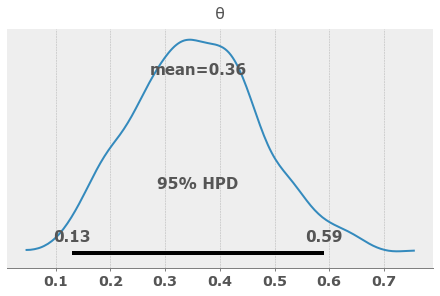

In [9]:
az.plot_posterior({'θ': posterior_samples}, credible_interval=0.95)
plt.show()

> Some points to Note 
- We see that the credible intervals are very large 0.13-0.61, these is because the data is very less (N=10). If we increase the data, the spread of credible intevals tend to reduce.
- Try to experiment with different shape parameters of prior distribution, we will get different posterior credible intevals. 
- As we increase the data, the output of the posterior will be same irrespective of the shape parameters of the prior.

## Using PyMC3
We will use pymc3 to solve the same problem

In [10]:
import pymc3 as pm

In [11]:
N = 10
np.random.seed(6)
success = 3

In [12]:
basic_model = pm.Model()

with basic_model:

    # Priors for unknown model parameters
    phi = pm.Beta('phi', alpha=2, beta=2)

    # Likelihood (sampling distribution) of observations
    Y_obs = pm.Binomial('Y_obs', n=N, p=phi, observed=3)

In the above we have defined the model using PyMC3. we will now use randomwalk metropolis hastings algorithm to calculate the posterior.

In [13]:
with basic_model:
    # draw 500 posterior samples
    trace = pm.sample(1000, step=pm.Metropolis())

Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [phi]
Sampling 4 chains, 0 divergences: 100%|██████████| 6000/6000 [00:00<00:00, 9269.52draws/s]
The number of effective samples is smaller than 25% for some parameters.


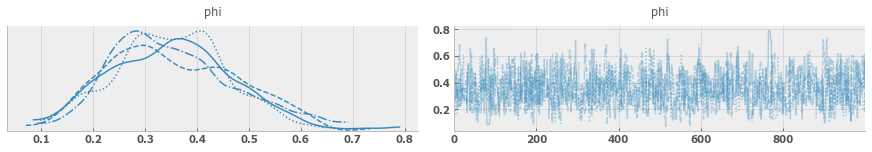

In [14]:
pm.traceplot(trace);

In [15]:
pm.summary(trace).round(3)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
phi,0.355,0.119,0.147,0.579,0.004,0.003,994.0,994.0,996.0,1127.0,1.01


- I will discuss about traceplot, summary statistics in a separate blog post where we discuss about the random walk metropolis hastings algorithm
- We can see that the mean is around ~0.35 with credible intervals [0.147, 0.579], similar to our analytical approach we have taken at the beginning.
- The key takeaways from here is that without using calculas to calculate the integral, we used pymc3 randomwalk metropolis sampling alogrithm to estimate the $\theta$. 
- Conjucate prior is a convinent way to calculate posterior analytically but a lot of times we are usually restricted by the usuage of priors. choosing priors from conjucate will be overally restrictive. Finally, we choose priors based on our beliefs but not because it is a conjucate to some likelihoods. In these cases PyMC3 will help us a lot with different sampling methods like metropolis hasting, NUTS, Gibbs etc. 

Thank you.

<script src="https://utteranc.es/client.js"
        repo="carbon2silicon"
        issue-term="pathname"
        theme="github-light"
        crossorigin="anonymous"
        async>
</script>